In [1]:
import sys
import os

# Add parent folder to path so Python can find src/
sys.path.append(os.path.abspath(".."))


from data_ingestion.data_handler import MortalityDataHandler
from data_ingestion.visualise_data import plot_mortality_surface
from models.lee_carter import LeeCarterModel
from models.visualise_forecast import plot_kt_forecast
from valuation.pension_model import PensionLiabilityModel
from quant.longevity_swap import LongevitySwapPricer
from utils.finance import get_real_yield_curve_example
from analyse_results import calculate_risk_metrics, plot_hedging_effectiveness

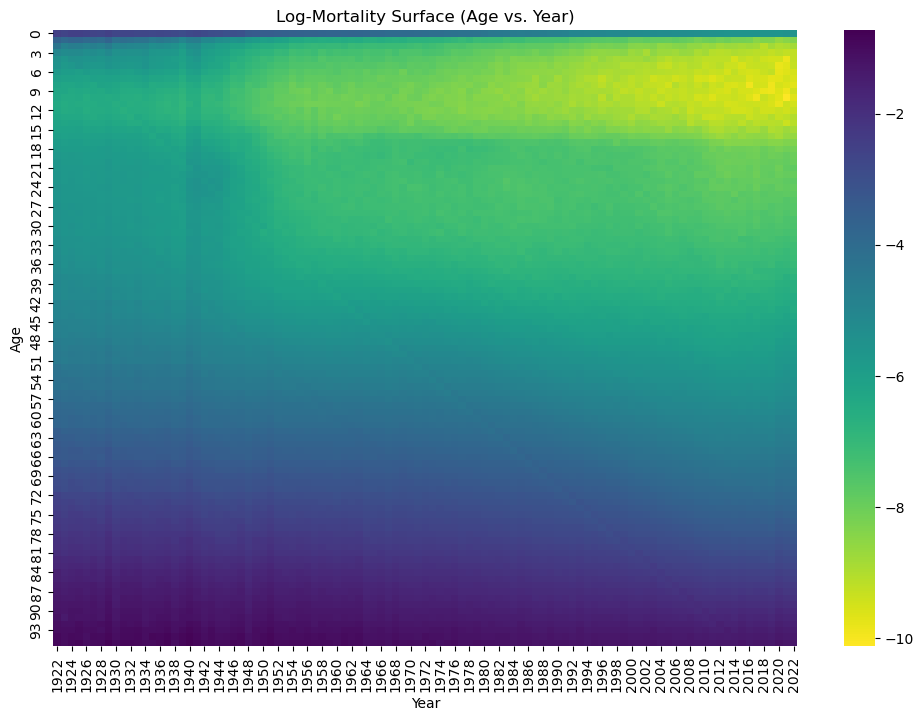

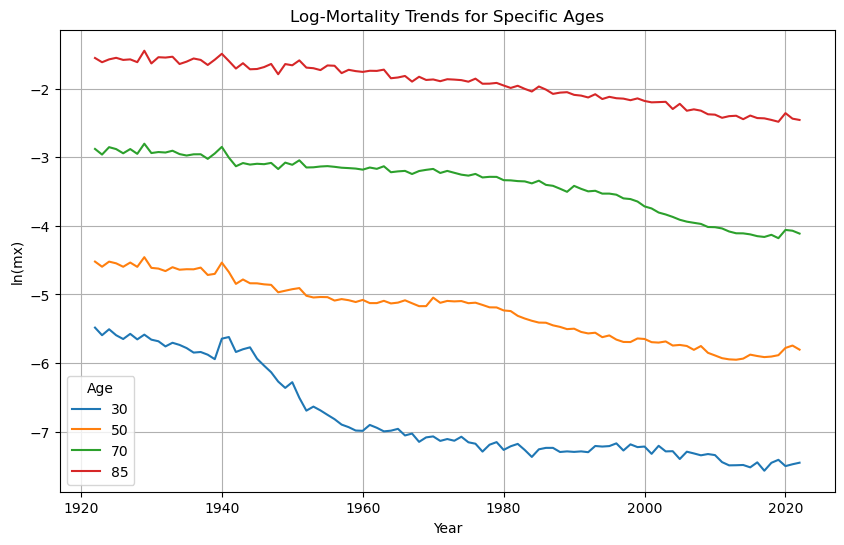

In [4]:
# 1. Setup Data
handler = MortalityDataHandler('/Users/willtrevarthen/longevity_engine/data/Mx_1x1.txt')
mx = handler.preprocess(min_age=0, max_age=95)
log_mx = handler.get_log_mortality()
# (Optional) Visualize Data
plot_mortality_surface(log_mx)



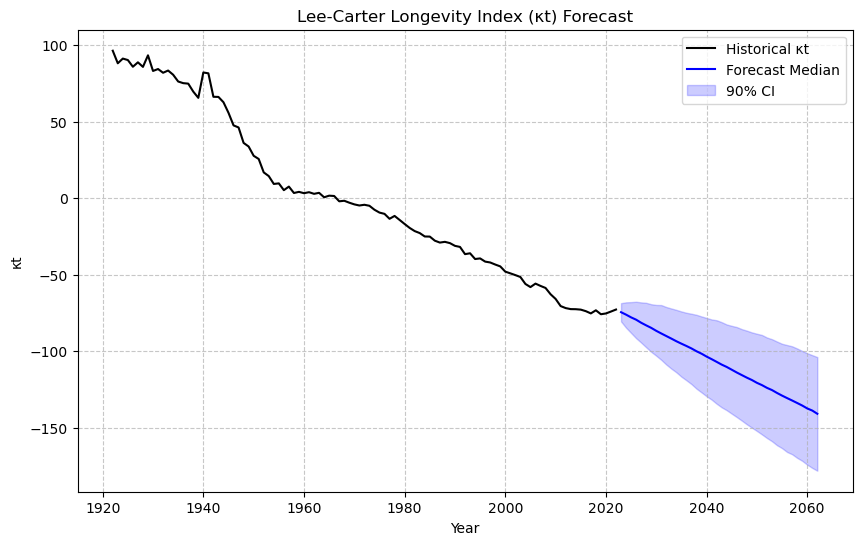

In [5]:
# 2. Fit and Forecast
model = LeeCarterModel().fit(log_mx)
forecast = model.predict(years_to_forecast=40, n_sims=5000)
# (Optional) Visualize kt Forecast
plot_kt_forecast(handler.matrix.columns, model.kt, forecast['kt_forecasts'])



In [6]:
# 3. Value Liability
pension = PensionLiabilityModel(initial_age=65, initial_count=1000, annual_pension=10000)
surv_paths = pension.calculate_survival_paths(forecast['mx_forecasts'], start_age_idx=15)
cashflows = pension.project_cashflows(surv_paths)
yield_curve = get_real_yield_curve_example(len(cashflows))
unhedged_pvs = pension.present_value(cashflows, yield_curve)



In [7]:
# 4. Price and Apply Swap
pricer = LongevitySwapPricer(lambda_parameter=0.20)
swap_results = pricer.price_legs(
surv_paths, 
yield_curve, 
initial_count=1000, 
annual_pension=10000
)
# The Net Swap Value must be a vector of 5000 results (one for each sim)
net_swap_payments = swap_results['floating_leg_pvs'] - swap_results['fixed_leg_pv']

# The Hedged Position: 
# You pay the actual liability (unhedged_pvs) 
# BUT you receive the net swap payment (net_swap_payments)
# Hedged = Liability - (Floating - Fixed)
# This simplifies to: Hedged = Fixed_Leg_PV (a constant!)
hedged_pvs = unhedged_pvs - net_swap_payments



Risk Metrics: {'Unhedged': {'VaR_95': 194289488.6847091, 'ES_95': 194324839.95614773, 'StdDev': 118482.60923215652}, 'Hedged': {'VaR_95': 194511102.82694232, 'ES_95': 194511102.82694238, 'StdDev': 6.324274709082144e-08}}


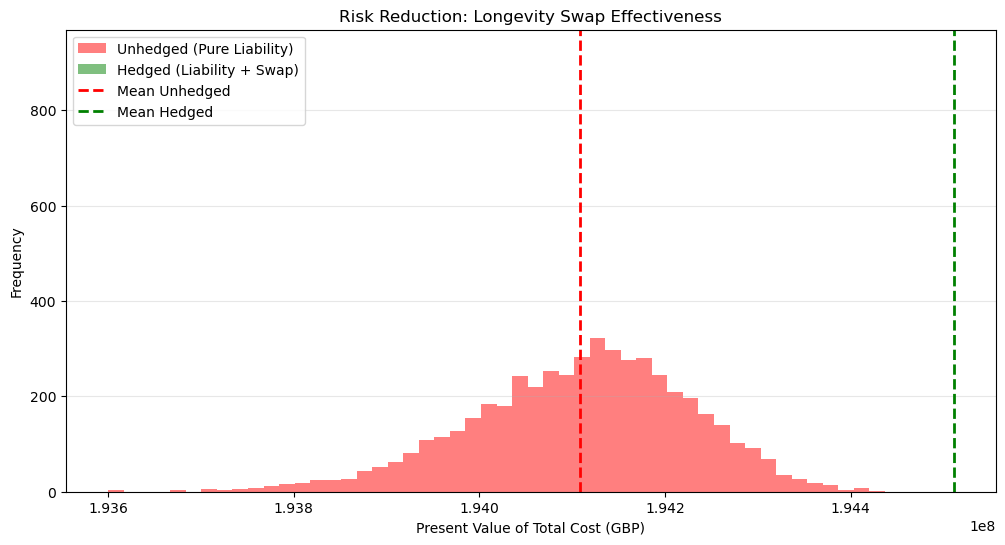

In [8]:
# 5. Analyze
# (Call your visualization functions here)
risk_metrics = calculate_risk_metrics(unhedged_pvs, hedged_pvs)
print("Risk Metrics:", risk_metrics)
plot_hedging_effectiveness(unhedged_pvs, hedged_pvs)